# Initialization


## Dowloads

In [2]:
# Dowloads (run this cell in case is the first time using the notebook)

import sys
'''
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pickle
!{sys.executable} -m pip install os
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install imp
!{sys.executable} -m pip install importlib
!{sys.executable} -m pip install IPython.display
'''


'\n!{sys.executable} -m pip install numpy\n!{sys.executable} -m pip install matplotlib\n!{sys.executable} -m pip install pickle\n!{sys.executable} -m pip install os\n!{sys.executable} -m pip install scipy\n!{sys.executable} -m pip install tqdm\n!{sys.executable} -m pip install imp\n!{sys.executable} -m pip install importlib\n!{sys.executable} -m pip install IPython.display\n'

## Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.constants import c, pi
from tqdm.notebook import tqdm  
from IPython.display import Image, display
import sys
import pickle as pck
import pandas as pd
import scipy as sci
%run Functions.py

In [4]:
# Creating lumerical integration
sys.path.append('../')
try:
    import imp
    try:
        os.add_dll_directory('C:\\Program Files\\Lumerical\\v202\\api\\python\\')
        lumapi = imp.load_source('lumapi','C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
    except:
        os.add_dll_directory('C:\\Program Files\\Lumerical\\v221\\api\\python\\')
        lumapi = imp.load_source('lumapi','C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py')
except:
    print('imp module not found. Trying with importlib...')
    from importlib.machinery import SourceFileLoader
    try:
        os.add_dll_directory('C:\\Program Files\\Lumerical\\v202\\api\\python\\')
        lumapi = SourceFileLoader('lumapi','C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py').load_module()
    except:
        os.add_dll_directory('C:\\Program Files\\Lumerical\\v221\\api\\python\\')
        lumapi = SourceFileLoader('lumapi','C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py').load_module()

imp module not found. Trying with importlib...


C:\Program Files\Lumerical\v202\api\python\lumapi.py:797: SyntaxWarning: invalid escape sequence '\s'
  message = re.sub('^(Error:)\s(prompt line)\s[0-9]+:', '', str(rvals[2])).strip()


## Intial Parameters

In [5]:
# General use variables 
λ0 = 1550e-9
π = pi
c0 = c

simulation_band = [1520e-9,1575e-9]
cband = [1530e-9, 1565e-9]

si = 'Si (Silicon) - Palik'
siO2 = 'SiO2 (Glass) - Palik'

# Ideal MZI with loss simulations

In [7]:
# Initializing INTERCONNECT
inter = lumapi.INTERCONNECT()

## Component initialization and test

In [8]:
component_name = 'MZI_WITH_LOSS'
loss = 0.48

inter.switchtolayout()
inter.deleteall()

# Creating cross MZI 

inter.addelement(component_name)
inter.set({'x position':0,
           'y position':300,
           'name': 'cross',
           'loss': loss,
           'Theta 1' : 0,
           'Theta 2' : 0})

# Creating Tunable Coupler 0.5/0.5 MZI

inter.addelement(component_name)
inter.set({'x position':400,
           'y position':300,
           'name': 'TC',
           'loss': loss,
           'Theta 1' : π/4,
           'Theta 2' : -π/4})

# Creating bar MZI

inter.addelement(component_name)
inter.set({'x position':800,
           'y position':300,
           'name': 'bar',
           'loss': loss,
           'Theta 1' : π,
           'Theta 2' : 0})

# Creating ONA for the MZIs

ports = 4
points = 100001

for i in range(3):
    addONA(inter, simulation_band[0],simulation_band[1],points,ports, i*400, 0)


# Connecting the ONAs and the MZIs

ConnectONA(inter, 'ONA_1', 'cross',[1,1,3,4,2])
ConnectONA(inter, 'ONA_2', 'TC',  [1,1,3,4,2])
ConnectONA(inter, 'ONA_3', 'bar', [1,1,3,4,2])

In [9]:
inter.run()

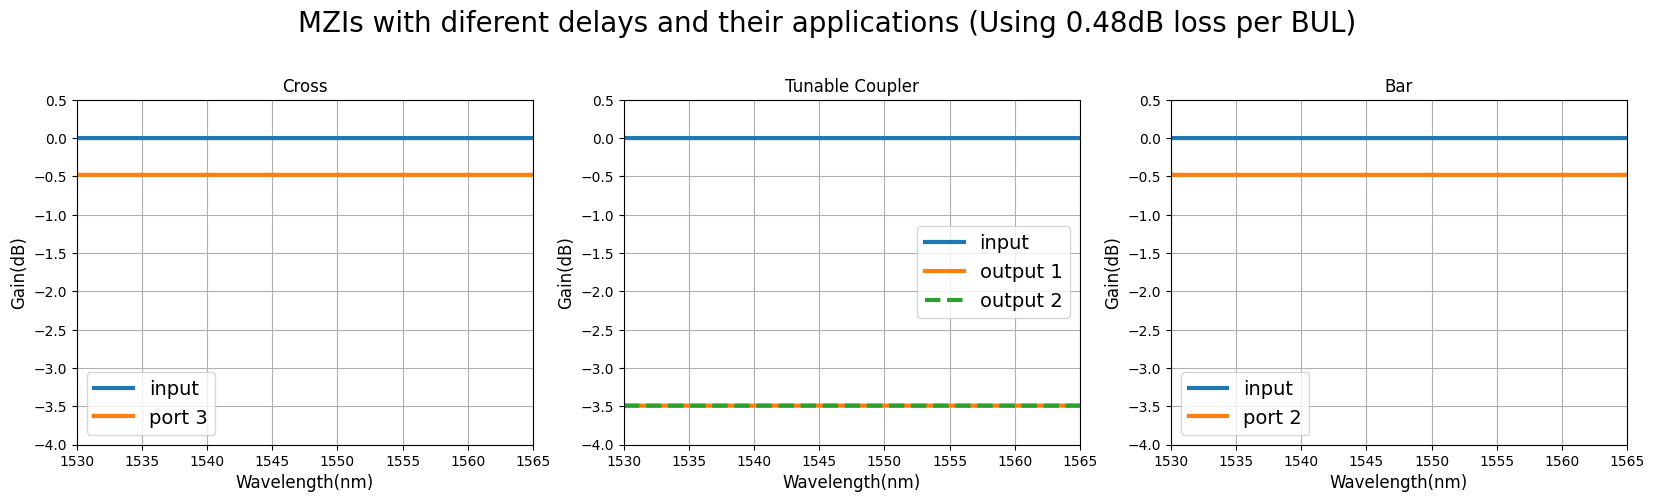

In [10]:
figure1,fig = plt.subplots(1,3,figsize=[20,5]);

gaincross = inter.getresult('ONA_1','input 3/mode 1/gain')['TE gain (dB)']
gainTC1 = inter.getresult('ONA_2','input 2/mode 1/gain')['TE gain (dB)']
gainTC2 = inter.getresult('ONA_2','input 3/mode 1/gain')['TE gain (dB)']
gainbar = inter.getresult('ONA_3','input 2/mode 1/gain')['TE gain (dB)']

λ = np.linspace(simulation_band[0]*1e9,simulation_band[-1]*1e9, points)
input = np.zeros(len(λ))

figure1.suptitle('MZIs with diferent delays and their applications (Using 0.48dB loss per BUL)', fontsize = 20)
figure1.subplots_adjust(top=0.8)

fig[0].set_title('Cross')
fig[0].grid()
fig[0].plot(λ, input, label= 'input', linewidth = 3)
fig[0].plot(λ, gaincross, label = 'port 3', linewidth = 3)
fig[0].legend(fontsize = 14)
fig[0].set_xlim(cband[0]*1e9,cband[-1]*1e9)
fig[0].set_ylim(-4,0.5)
fig[0].set_ylabel('Gain(dB)', fontsize=12)
fig[0].set_xlabel('Wavelength(nm)', fontsize=12)

fig[1].set_title('Tunable Coupler')
fig[1].grid()
fig[1].plot(λ, input, label= 'input', linewidth = 3)
fig[1].plot(λ, gainTC1, label = 'output 1', linewidth = 3)
fig[1].plot(λ, gainTC1,'--', label = 'output 2', linewidth = 3)
fig[1].legend(fontsize = 14)
fig[1].set_xlim(cband[0]*1e9,cband[-1]*1e9)
fig[1].set_ylim(-4,0.5)
fig[1].set_ylabel('Gain(dB)', fontsize=12)
fig[1].set_xlabel('Wavelength(nm)', fontsize=12)

fig[2].set_title('Bar')
fig[2].grid()
fig[2].plot(λ, input, label= 'input', linewidth = 3)
fig[2].plot(λ, gaincross, label = 'port 2', linewidth = 3)
fig[2].legend(fontsize = 14)
fig[2].set_xlim(cband[0]*1e9,cband[-1]*1e9)
fig[2].set_ylim(-4,0.5)
fig[2].set_ylabel('Gain(dB)', fontsize=12)
fig[2].set_xlabel('Wavelength(nm)', fontsize=12);

# Creating an UMZI filter

In [5]:
# Initializing INTERCONNECT
inter = lumapi.INTERCONNECT()

In [6]:
display(Image(filename='../Media/Ilustration/UMZI.png', width=1500))

FileNotFoundError: [Errno 2] No such file or directory: '../Media/Ilustration/UMZI.png'

### With loss

In [12]:
# Unitary UMZI cell
bar = 1
cross = 1
tc = 1
component_name = 'MZI_WITH_LOSS'
loss = 0.48

inter.switchtolayout()
inter.selectall()
inter.delete()

# Create the MZIs

inter.addelement(component_name)
inter.set({'x position':-200,'y position':800,'name': 'TC_'+str(tc),'loss': loss,'Theta 1' : π/2});tc+=1

inter.copy()
inter.set({'x position':300,'y position':600,'name': 'cross_'+str(cross),'Theta 1' : 0});cross+=1

inter.copy()
inter.set({'x position':600,'y position':500,'name': 'cross_'+str(cross),'Theta 1' : 0});cross+=1

inter.copy()
inter.set({'x position':600,'y position':300,'name': 'cross_'+str(cross),'Theta 1' : 0});cross+=1

inter.copy()
inter.set({'x position':300,'y position':100,'name': 'bar_'+str(bar), 'Theta 1' : π});bar+=1

inter.copy()
inter.set({'x position':0,'y position':300,'name': 'bar_'+str(bar), 'Theta 1' : π});bar+=1

inter.copy()
inter.set({'x position':0,'y position':500,'name': 'cross_'+str(cross),'Theta 1' : 0});cross+=1

inter.copy()
inter.set({'x position':900,'y position':400,'name': 'TC_'+str(tc),'Theta 1' : π/2});tc+=1

# Connect the MZIs

Connectcomponents(inter,'TC_1',[4],'cross_1', [2])
Connectcomponents(inter,'cross_1', [3], 'cross_2', [1])
Connectcomponents(inter,'cross_2', [4], 'TC_2', [2])
Connectcomponents(inter,'cross_3', [3], 'TC_2', [1])
Connectcomponents(inter,'cross_3', [2], 'bar_1', [4])
Connectcomponents(inter,'bar_2', [4], 'bar_1', [2])
Connectcomponents(inter,'bar_2', [2], 'cross_4', [1])
Connectcomponents(inter,'cross_4', [4], 'TC_1', [3])
Connectcomponents(inter,'cross_4', [3], 'cross_1', [1])
Connectcomponents(inter,'cross_2', [3], 'cross_3', [4])

# Create the ONA
ports = 4
points = 10001
addONA(inter, simulation_band[0],simulation_band[1],points,ports,-250, 0)

inter.connect('ONA_1', 'output', 'TC_1', 'port 1')
inter.connect('ONA_1', 'input 1', 'TC_2', 'port 3')
inter.connect('ONA_1', 'input 2', 'TC_2', 'port 4')
inter.connect('ONA_1', 'input 3', 'cross_3', 'port 3')
inter.connect('ONA_1', 'input 4', 'cross_2', 'port 4');

inter.run()

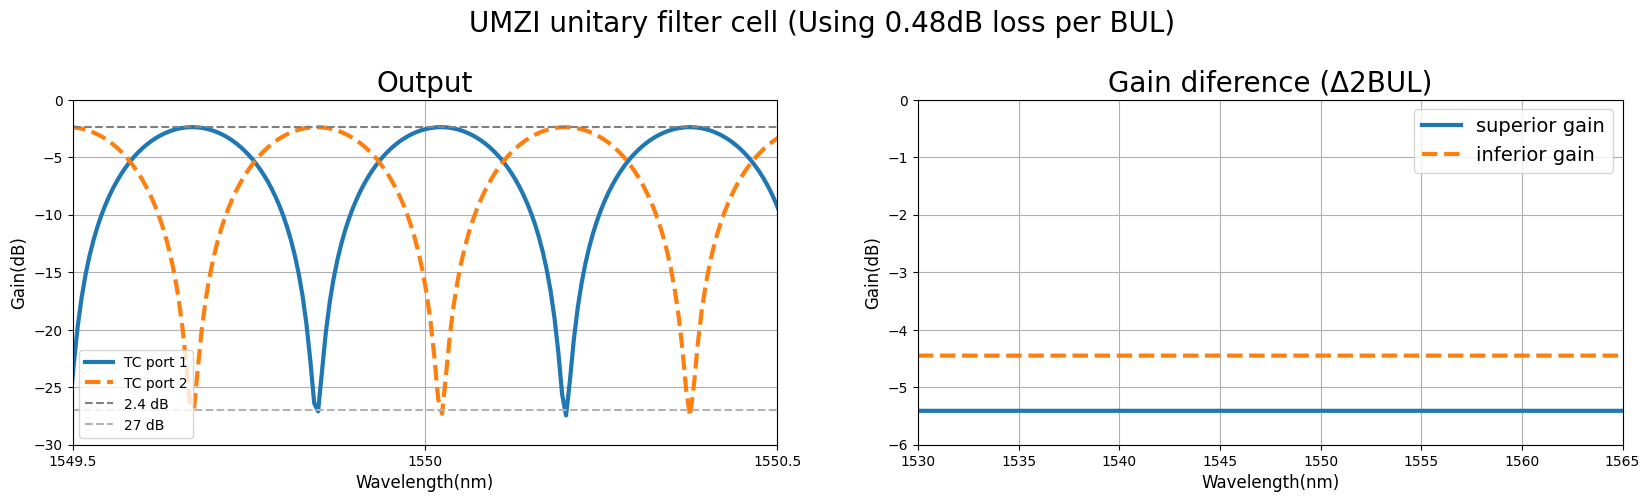

In [110]:
figure2,fig = plt.subplots(1,2,figsize=[20,5]);

gainTC_2p3 = inter.getresult('ONA_1','input 1/mode 1/gain')['TE gain (dB)']
gainTC_2p4 = inter.getresult('ONA_1','input 2/mode 1/gain')['TE gain (dB)']
gaincross_3p3 = inter.getresult('ONA_1','input 3/mode 1/gain')['TE gain (dB)']
gaincross_2p4 = inter.getresult('ONA_1','input 4/mode 1/gain')['TE gain (dB)']

λ = np.linspace(simulation_band[0]*1e9,simulation_band[-1]*1e9, points)

figure2.suptitle('UMZI unitary filter cell (Using 0.48dB loss per BUL)', fontsize = 20)
figure2.subplots_adjust(top=0.8)

fig[0].set_title('Output', fontsize = 20)
fig[0].grid()
fig[0].plot(λ, gainTC_2p3, label= 'TC port 1', linewidth = 3)
fig[0].plot(λ, gainTC_2p4,'--', label = 'TC port 2', linewidth = 3)
fig[0].axhline(-2.4, label = '2.4 dB', color = 'grey', linestyle='--')
fig[0].axhline(-27, label = '27 dB', color = '0.7', linestyle='--')
fig[0].legend(fontsize = 10)
fig[0].set_xlim(1549.5,1550.5)
fig[0].set_ylim(-30,0)
fig[0].set_xticks([1549.5, 1550, 1550.5], ['1549.5', '1550', '1550.5'])
fig[0].set_ylabel('Gain(dB)', fontsize=12)
fig[0].set_xlabel('Wavelength(nm)', fontsize=12)

fig[1].set_title('Gain diference (Δ2BUL)', fontsize = 20)
fig[1].grid()
fig[1].plot(λ, gaincross_3p3, label = 'superior gain', linewidth = 3)
fig[1].plot(λ, gaincross_2p4,'--', label = 'inferior gain', linewidth = 3)
fig[1].legend(fontsize = 14)
fig[1].set_xlim(cband[0]*1e9,cband[-1]*1e9)
fig[1].set_ylim(-6,0)
fig[1].set_ylabel('Gain(dB)', fontsize=12)
fig[1].set_xlabel('Wavelength(nm)', fontsize=12)

figure2.savefig('../Media/UMZI Results/UMZI_unitary_cell_grain.png',bbox_inches='tight')

Text(0.5, 0, 'Wavelength(nm)')

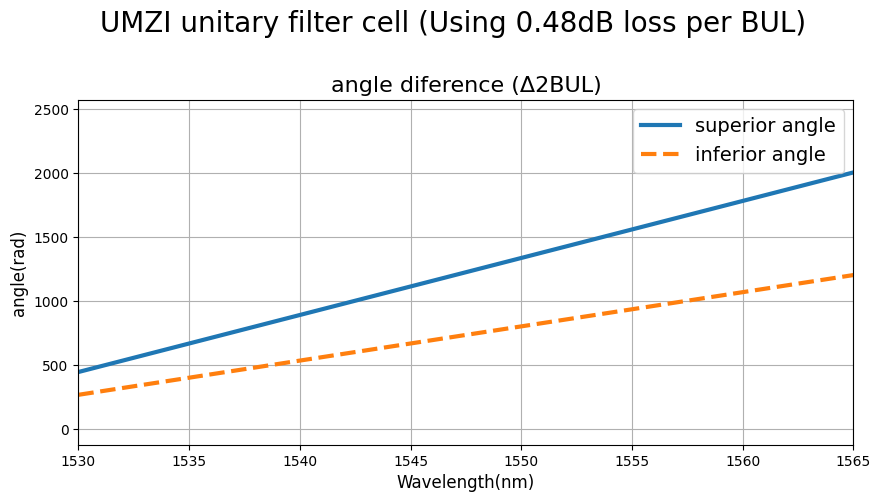

In [10]:
# Plot phase

figure3= plt.figure(figsize=[10,5]);

angleTC_2p3 = inter.getresult('ONA_1','input 1/mode 1/angle')['TE angle (rad)']
angleTC_2p4 = inter.getresult('ONA_1','input 2/mode 1/angle')['TE angle (rad)']
anglecross_3p3 = inter.getresult('ONA_1','input 3/mode 1/angle')['TE angle (rad)']
anglecross_2p4 = inter.getresult('ONA_1','input 4/mode 1/angle')['TE angle (rad)']

λ = np.linspace(simulation_band[0]*1e9,simulation_band[-1]*1e9, points)

figure3.suptitle('UMZI unitary filter cell (Using 0.48dB loss per BUL)', fontsize = 20)
figure3.subplots_adjust(top=0.8)

plt.title('angle diference (Δ2BUL)', fontsize = 16)
plt.grid()
plt.plot(λ, anglecross_3p3, label = 'superior angle', linewidth = 3)
plt.plot(λ, anglecross_2p4,'--', label = 'inferior angle', linewidth = 3)
plt.legend(fontsize = 14)
plt.xlim(cband[0]*1e9,cband[-1]*1e9)
plt.ylabel('angle(rad)', fontsize=12)
plt.xlabel('Wavelength(nm)', fontsize=12)

### Without Loss

In [6]:
# Unitary UMZI cell
bar = 1
cross = 1
tc = 1
component_name = 'MZI_IDEAL_CELL'

inter.switchtolayout()
inter.selectall()
inter.delete()

# Create the MZIs

inter.addelement(component_name)
inter.set({'x position':-200,'y position':800,'name': 'TC_'+str(tc),'Theta 1' : π/2});tc+=1

inter.copy()
inter.set({'x position':300,'y position':600,'name': 'cross_'+str(cross),'Theta 1' : 0});cross+=1

inter.copy()
inter.set({'x position':600,'y position':500,'name': 'cross_'+str(cross)});cross+=1

inter.copy()
inter.set({'x position':600,'y position':300,'name': 'cross_'+str(cross)});cross+=1

inter.copy()
inter.set({'x position':300,'y position':100,'name': 'bar_'+str(bar), 'Theta 1' : π});bar+=1

inter.copy()
inter.set({'x position':0,'y position':300,'name': 'bar_'+str(bar)});bar+=1

inter.copy()
inter.set({'x position':0,'y position':500,'name': 'cross_'+str(cross),'Theta 1' : 0});cross+=1

inter.copy()
inter.set({'x position':900,'y position':400,'name': 'TC_'+str(tc),'Theta 1' : π/2});tc+=1

# Connect the MZIs

Connectcomponents(inter,'TC_1',[4],'cross_1', [2])
Connectcomponents(inter,'cross_1', [3], 'cross_2', [1])
Connectcomponents(inter,'cross_2', [4], 'TC_2', [2])
Connectcomponents(inter,'cross_3', [3], 'TC_2', [1])
Connectcomponents(inter,'cross_3', [2], 'bar_1', [4])
Connectcomponents(inter,'bar_2', [4], 'bar_1', [2])
Connectcomponents(inter,'bar_2', [2], 'cross_4', [1])
Connectcomponents(inter,'cross_4', [4], 'TC_1', [3])
Connectcomponents(inter,'cross_4', [3], 'cross_1', [1])
Connectcomponents(inter,'cross_2', [3], 'cross_3', [4])

# Create the ONA
ports = 4
points = 10001
addONA(inter, simulation_band[0],simulation_band[1],points,ports,-250, 0)

inter.connect('ONA_1', 'output', 'TC_1', 'port 1')
inter.connect('ONA_1', 'input 1', 'TC_2', 'port 3')
inter.connect('ONA_1', 'input 2', 'TC_2', 'port 4')
inter.connect('ONA_1', 'input 3', 'cross_3', 'port 3')
inter.connect('ONA_1', 'input 4', 'cross_2', 'port 4');

inter.run()

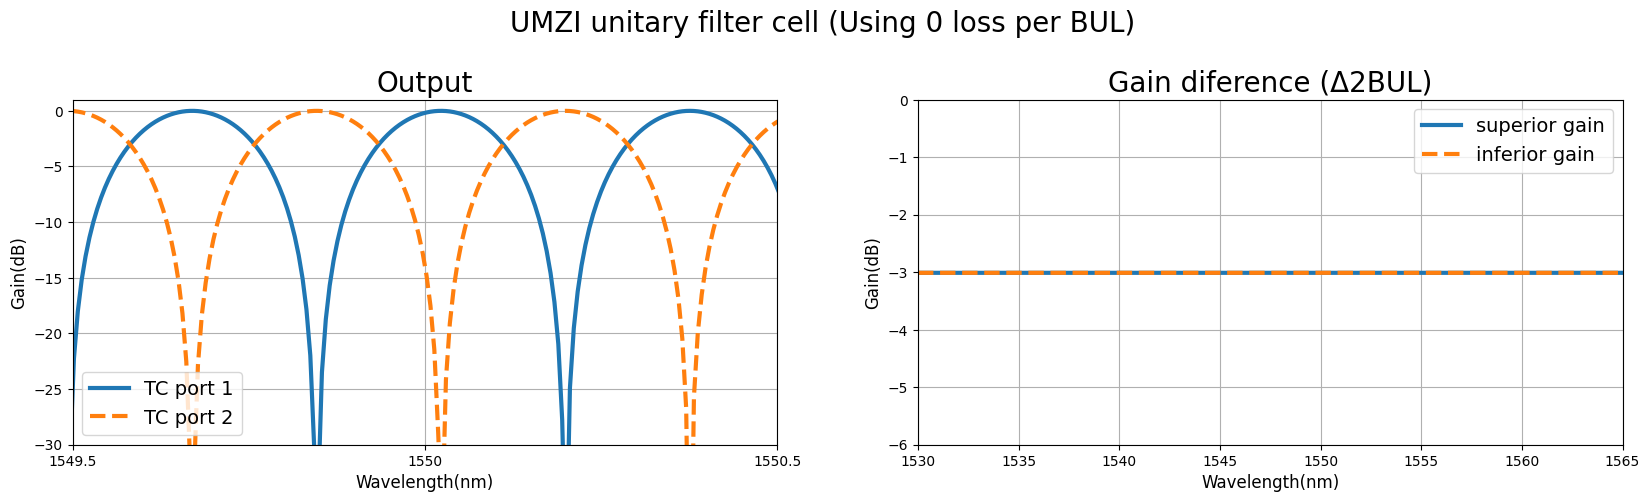

In [12]:
figure4,fig = plt.subplots(1,2,figsize=[20,5]);

gainTC_2p3 = inter.getresult('ONA_1','input 1/mode 1/gain')['TE gain (dB)']
gainTC_2p4 = inter.getresult('ONA_1','input 2/mode 1/gain')['TE gain (dB)']
gaincross_3p3 = inter.getresult('ONA_1','input 3/mode 1/gain')['TE gain (dB)']
gaincross_2p4 = inter.getresult('ONA_1','input 4/mode 1/gain')['TE gain (dB)']

λ = np.linspace(simulation_band[0]*1e9,simulation_band[-1]*1e9, points)

figure4.suptitle('UMZI unitary filter cell (Using 0 loss per BUL)', fontsize = 20)
figure4.subplots_adjust(top=0.8)

fig[0].set_title('Output', fontsize = 20)
fig[0].grid()
fig[0].plot(λ, gainTC_2p3, label= 'TC port 1', linewidth = 3)
fig[0].plot(λ, gainTC_2p4,'--', label = 'TC port 2', linewidth = 3)

fig[0].legend(fontsize = 14)
fig[0].set_xlim(1549.5,1550.5)
fig[0].set_ylim(-30,1)
fig[0].set_xticks([1549.5, 1550, 1550.5], ['1549.5', '1550', '1550.5'])
fig[0].set_ylabel('Gain(dB)', fontsize=12)
fig[0].set_xlabel('Wavelength(nm)', fontsize=12)

fig[1].set_title('Gain diference (Δ2BUL)', fontsize = 20)
fig[1].grid()
fig[1].plot(λ, gaincross_3p3, label = 'superior gain', linewidth = 3)
fig[1].plot(λ, gaincross_2p4,'--', label = 'inferior gain', linewidth = 3)
fig[1].legend(fontsize = 14)
fig[1].set_xlim(cband[0]*1e9,cband[-1]*1e9)
fig[1].set_ylim(-6,0)
fig[1].set_ylabel('Gain(dB)', fontsize=12)
fig[1].set_xlabel('Wavelength(nm)', fontsize=12)

figure4.savefig('../Media/UMZI Results/UMZI_unitary_cell_grain_ideal.png',bbox_inches='tight')

## MZI Hex Simulation and UMZI Third Order Generation

In [5]:
inter = lumapi.INTERCONNECT()

In [6]:
loss = 0.48
process = inter

cross = [0,0]
bar = [π,0]
Tc = [π/2,0]

inter.switchtolayout()
inter.selectall()
inter.delete()

# Creating first filter ring
theta_matrix1 = [bar,cross,cross,cross,cross,bar]
GenerateHexMZI(loss, process, theta_matrix1)
inter.set({'x position':200,'y position':400})

# Creating second filter ring
theta_matrix2 = [bar,bar,cross,cross,cross,cross]
GenerateHexMZI(loss, process, theta_matrix2)
inter.set({'x position':1200,'y position':400})
# Creating Third filter ring
theta_matrix3 = [cross,cross,cross,bar,bar,cross]
GenerateHexMZI(loss, process, theta_matrix3)
inter.set({'x position':1800,'y position':1000})

# Input MZI
inter.addelement('MZI_WITH_LOSS')
inter.set({'name': 'TC_in','Theta 1' : π/2,'x position':-200,'y position':800, 'Loss': loss});

# Filter 1 to 2 MZI
inter.addelement('MZI_WITH_LOSS')
inter.set({'name': 'TC_1-2','Theta 1' : π/2, 'x position':900,'y position':600, 'Loss': loss});

# Filter 2 to 3 MZI
inter.addelement('MZI_WITH_LOSS')
inter.set({'name': 'TC_2-3','Theta 1' : π/2, 'x position':1400,'y position':1000, 'Loss': loss});

# Filter 3 to out
inter.addelement('MZI_WITH_LOSS')
inter.set({'name': 'TC_out','Theta 1' : π/2, 'x position':2400,'y position':1000, 'Loss': loss});


for i in range(5):
   # Bar to out
    inter.addelement('MZI_WITH_LOSS')
    inter.set({'name': 'Bar'+str(i+1),'Theta 1' : π, 'x position':2700+i*300,'y position':1000}); 

# Connections

Connectcomponents(inter, 'TC_in',[3,4], 'MZI_HEX_1', [9,8])   # Tc_In to Filter 1
Connectcomponents(inter, 'MZI_HEX_1',[4,5], 'TC_1-2',[1,2])   # Filter 1 to Tc_1-2
Connectcomponents(inter, 'TC_1-2',[3,4],'MZI_HEX_2', [11,10]) # Tc_1-2 to Filter 2
Connectcomponents(inter, 'MZI_HEX_2',[6,7], 'TC_2-3',[1,2])   # Filter 2 to Tc_2-3
Connectcomponents(inter, 'TC_2-3',[3,4], 'MZI_HEX_3',[1,12])  # Tc 2-3 to Filter 3
Connectcomponents(inter, 'MZI_HEX_3',[4,5], 'TC_out',[1,2])   # Filter 3 to Tc_out
Connectcomponents(inter, 'TC_out',[3,4], 'Bar1', [1,2])       # Tc_out to Bar1
Connectcomponents(inter, 'Bar1',[3,4], 'Bar2', [1,2])         # Bar1 to Bar2
Connectcomponents(inter, 'Bar2',[3,4], 'Bar3', [1,2])         # Bar2 to Bar3
Connectcomponents(inter, 'Bar3',[3,4], 'Bar4', [1,2])         # Bar3 to Bar4
Connectcomponents(inter, 'Bar4',[3,4], 'Bar5', [1,2])         # Bar4 to Bar5

ports = 6
points = 10001
addONA(inter, simulation_band[0],simulation_band[1],points,ports,250, 250)

inter.connect('ONA_1','output', 'TC_in', 'port 1')
inter.connect('ONA_1','input 1', 'TC_1-2', 'port 3')
inter.connect('ONA_1','input 2', 'TC_1-2', 'port 4');
inter.connect('ONA_1','input 3', 'TC_2-3', 'port 3')
inter.connect('ONA_1','input 4', 'TC_2-3', 'port 4');
inter.connect('ONA_1','input 5', 'Bar5', 'port 3')
inter.connect('ONA_1','input 6', 'Bar5', 'port 4');

In [8]:
inter.run()

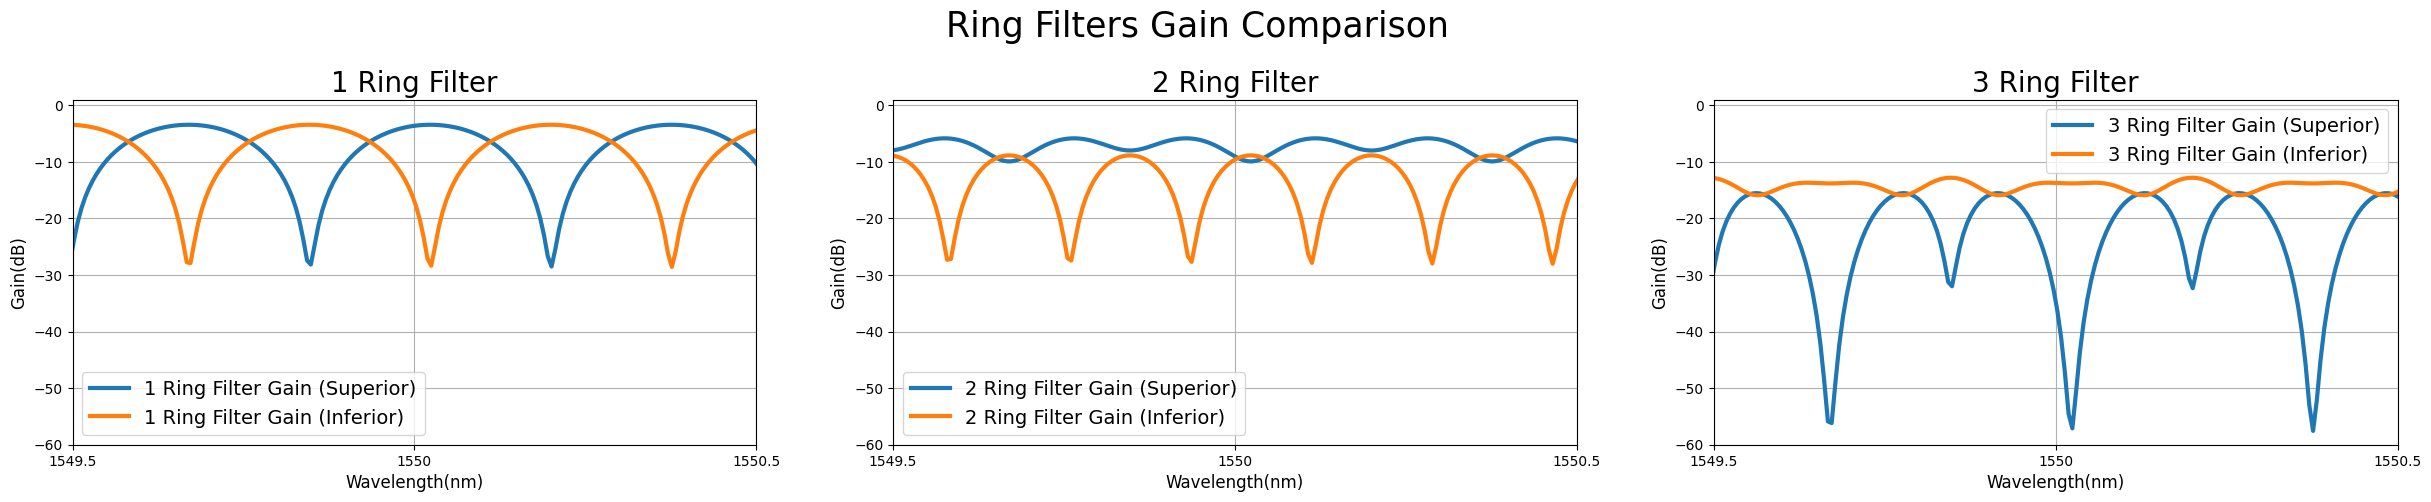

In [11]:
ring1_gain1 = inter.getresult('ONA_1','input 1/mode 1/gain')['TE gain (dB)']
ring1_gain2 = inter.getresult('ONA_1','input 2/mode 1/gain')['TE gain (dB)']
ring2_gain1 = inter.getresult('ONA_1','input 3/mode 1/gain')['TE gain (dB)']
ring2_gain2 = inter.getresult('ONA_1','input 4/mode 1/gain')['TE gain (dB)']
out_gain1 = inter.getresult('ONA_1','input 5/mode 1/gain')['TE gain (dB)']
out_gain2 = inter.getresult('ONA_1','input 6/mode 1/gain')['TE gain (dB)']

λ = np.linspace(simulation_band[0]*1e9,simulation_band[-1]*1e9, points)
figure5, fig = plt.subplots(1, 3, figsize=[30, 5])

figure5.suptitle('Ring Filters Gain Comparison', fontsize=25)
figure5.subplots_adjust(top=0.8)

fig[0].set_title('1 Ring Filter', fontsize=20)
fig[0].grid()
fig[0].plot(λ, ring1_gain1, label='1 Ring Filter Gain (Superior)', linewidth=3)
fig[0].plot(λ, ring1_gain2, label='1 Ring Filter Gain (Inferior)', linewidth=3)
fig[0].legend(fontsize=14)
fig[0].set_xlim(1549.5, 1550.5)
fig[0].set_ylim(-60, 1)
fig[0].set_xticks([1549.5, 1550, 1550.5], ['1549.5', '1550', '1550.5'])
fig[0].set_ylabel('Gain(dB)', fontsize=12)
fig[0].set_xlabel('Wavelength(nm)', fontsize=12)

fig[1].set_title('2 Ring Filter', fontsize=20)
fig[1].grid()
fig[1].plot(λ, ring2_gain1, label='2 Ring Filter Gain (Superior)', linewidth=3)
fig[1].plot(λ, ring2_gain2, label='2 Ring Filter Gain (Inferior)', linewidth=3)
fig[1].legend(fontsize=14)
fig[1].set_xlim(1549.5, 1550.5)
fig[1].set_ylim(-60, 1)
fig[1].set_xticks([1549.5, 1550, 1550.5], ['1549.5', '1550', '1550.5'])
fig[1].set_ylabel('Gain(dB)', fontsize=12)
fig[1].set_xlabel('Wavelength(nm)', fontsize=12)


fig[2].set_title('3 Ring Filter', fontsize=20)
fig[2].grid()
fig[2].plot(λ, out_gain1, label='3 Ring Filter Gain (Superior)' , linewidth=3)
fig[2].plot(λ, out_gain2, label='3 Ring Filter Gain (Inferior)', linewidth=3)
fig[2].legend(fontsize=14)
fig[2].set_xlim(1549.5, 1550.5)
fig[2].set_ylim(-60, 1)
fig[2].set_xticks([1549.5, 1550, 1550.5], ['1549.5', '1550', '1550.5'])
fig[2].set_ylabel('Gain(dB)', fontsize=12)
fig[2].set_xlabel('Wavelength(nm)', fontsize=12)

# Salvar a figura
figure5.savefig('../Media/Ring_Filters_Comparison.png', bbox_inches='tight')


## Testing the BUL diference

In [5]:
# Initializing INTERCONNECT
inter = lumapi.INTERCONNECT();

In [11]:
# Creating 4 BUL diference

loss = 0.48
process = inter

cross = [0,0]
bar = [π,0]
Tc = [π/2,0]

inter.switchtolayout()
inter.selectall()
inter.delete()

# Creating  filter rings
theta_matrix = [cross,bar,cross,cross,cross,bar]
GenerateHexMZI(loss, process, theta_matrix)
inter.set({'x position':500,'y position':200})

theta_matrix = [bar,bar,cross,bar,cross,cross]
GenerateHexMZI(loss, process, theta_matrix)
inter.set({'x position':1200,'y position':0})

# Input MZI
inter.addelement('MZI_WITH_LOSS')
inter.set({'name': 'TC_in','Theta 1' : π/2,'x position':0,'y position':600, 'Loss': loss});

# Output MZI
inter.addelement('MZI_WITH_LOSS')
inter.set({'name': 'TC_out','Theta 1' : π/2,'x position':1800,'y position':600, 'Loss': loss});

Connectcomponents(inter, 'TC_in',[3,4],'MZI_HEX_1', [9,8]) # Tc_in to Filter 
Connectcomponents(inter, 'MZI_HEX_1',[2,3,5,4], 'MZI_HEX_2', [11,10,8,9]) # Cell 1 to Cell 2
Connectcomponents(inter, 'MZI_HEX_2',[6,7], 'TC_out',[1,2])  # Filter to Tc_out

ports = 6
points = 10001
addONA(inter, simulation_band[0],simulation_band[1],points,ports,250, 100)

inter.connect('ONA_1','output', 'TC_in', 'port 1')

inter.connect('ONA_1','input 1', 'TC_out', 'port 3')
inter.connect('ONA_1','input 2', 'TC_out', 'port 4');
inter.connect('ONA_1','input 3', 'MZI_HEX_2', 'port 6')
inter.connect('ONA_1','input 4', 'MZI_HEX_2', 'port 7');



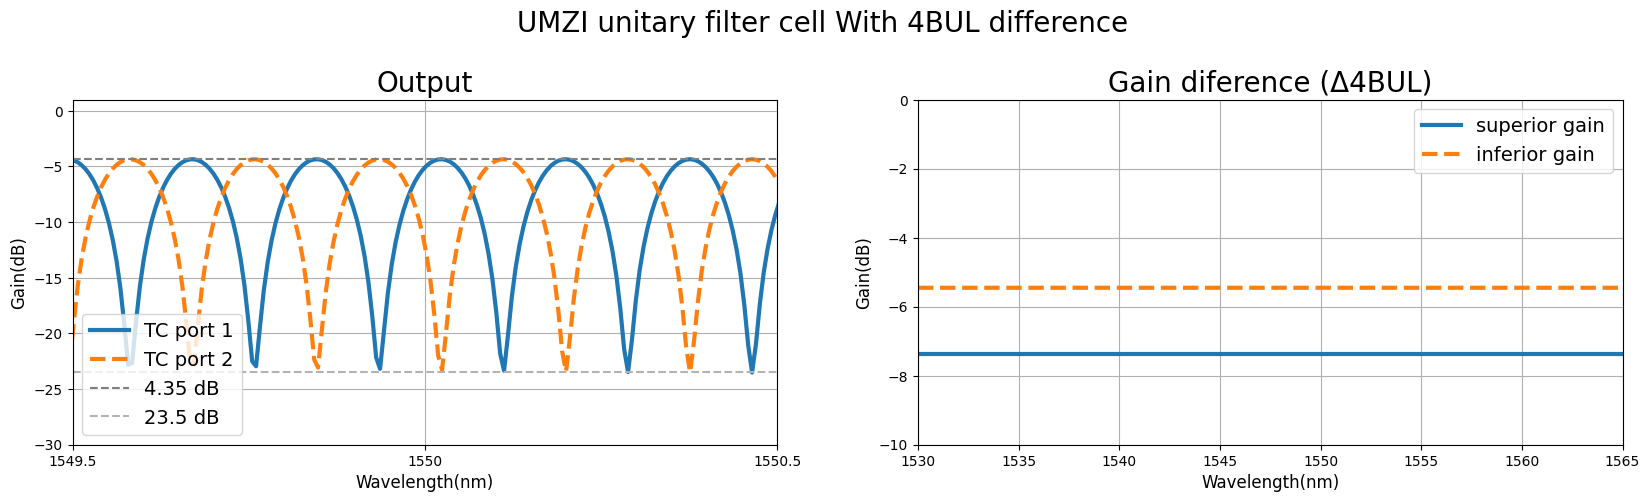

In [24]:
figure6,fig = plt.subplots(1,2,figsize=[20,5]);

#inter.run()

gainTC_2p3 = inter.getresult('ONA_1','input 1/mode 1/gain')['TE gain (dB)']
gainTC_2p4 = inter.getresult('ONA_1','input 2/mode 1/gain')['TE gain (dB)']
gaincross_3p3 = inter.getresult('ONA_1','input 3/mode 1/gain')['TE gain (dB)']
gaincross_2p4 = inter.getresult('ONA_1','input 4/mode 1/gain')['TE gain (dB)']

λ = np.linspace(simulation_band[0]*1e9,simulation_band[-1]*1e9, points)

figure6.suptitle('UMZI unitary filter cell With 4BUL difference', fontsize = 20)
figure6.subplots_adjust(top=0.8)

fig[0].set_title('Output', fontsize = 20)
fig[0].grid()
fig[0].plot(λ, gainTC_2p3, label= 'TC port 1', linewidth = 3)
fig[0].plot(λ, gainTC_2p4,'--', label = 'TC port 2', linewidth = 3)
fig[0].set_xlim(1549.5,1550.5)
fig[0].set_ylim(-30,1)
fig[0].set_xticks([1549.5, 1550, 1550.5], ['1549.5', '1550', '1550.5'])
fig[0].set_ylabel('Gain(dB)', fontsize=12)
fig[0].set_xlabel('Wavelength(nm)', fontsize=12)
fig[0].axhline(-4.35, label = '4.35 dB', color = 'grey', linestyle='--')
fig[0].axhline(-23.5, label = '23.5 dB', color = '0.7', linestyle='--')
fig[0].legend(fontsize = 14)

fig[1].set_title('Gain diference (Δ4BUL)', fontsize = 20)
fig[1].grid()
fig[1].plot(λ, gaincross_3p3, label = 'superior gain', linewidth = 3)
fig[1].plot(λ, gaincross_2p4,'--', label = 'inferior gain', linewidth = 3)
fig[1].legend(fontsize = 14)
fig[1].set_xlim(cband[0]*1e9,cband[-1]*1e9)
fig[1].set_ylim(-10,0)
fig[1].set_ylabel('Gain(dB)', fontsize=12)
fig[1].set_xlabel('Wavelength(nm)', fontsize=12)

figure6.savefig('../Media/UMZI Results/UMZI_unitary_cell_4BUL.png',bbox_inches='tight')

In [13]:
# Creating 6 BUL diference

loss = 0.48
process = inter

cross = [0,0]
bar = [π,0]
Tc = [π/2,0]

inter.switchtolayout()
inter.selectall()
inter.delete()

# Creating  filter rings
theta_matrix1 = [cross,bar,cross,cross,cross,bar]
GenerateHexMZI(loss, process, theta_matrix1)
inter.set({'x position':500,'y position':200})

theta_matrix2 = [bar,cross,cross,bar,cross,cross]
GenerateHexMZI(loss, process, theta_matrix2)
inter.set({'x position':1200,'y position':0})

theta_matrix3 = [cross,bar,bar,cross,bar,cross]
GenerateHexMZI(loss, process, theta_matrix3)
inter.set({'x position':1900,'y position':200})

# Input MZI
inter.addelement('MZI_WITH_LOSS')
inter.set({'name': 'TC_in','Theta 1' : π/2,'x position':0,'y position':600, 'Loss': loss});

# Output MZI
inter.addelement('MZI_WITH_LOSS')
inter.set({'name': 'TC_out','Theta 1' : π/2,'x position':1600,'y position':600, 'Loss': loss});

Connectcomponents(inter, 'TC_in',[3,4],'MZI_HEX_1', [9,8]) # Tc_in to Filter 
Connectcomponents(inter, 'MZI_HEX_1',[2,3,5,4], 'MZI_HEX_2', [11,10,8,9]) # Cell 1 to Cell 2
Connectcomponents(inter, 'MZI_HEX_2',[4,5,6,7], 'MZI_HEX_3', [1,12,11,10]) # Cell 2 to Cell 3
Connectcomponents(inter, 'MZI_HEX_3',[9,8], 'TC_out',[3,4])  # Filter to Tc_out

ports = 6
points = 10001
addONA(inter, simulation_band[0],simulation_band[1],points,ports,250, 100)

inter.connect('ONA_1','output', 'TC_in', 'port 1')

inter.connect('ONA_1','input 1', 'TC_out', 'port 1')
inter.connect('ONA_1','input 2', 'TC_out', 'port 2');
inter.connect('ONA_1','input 3', 'MZI_HEX_3', 'port 9')
inter.connect('ONA_1','input 4', 'MZI_HEX_3', 'port 8');



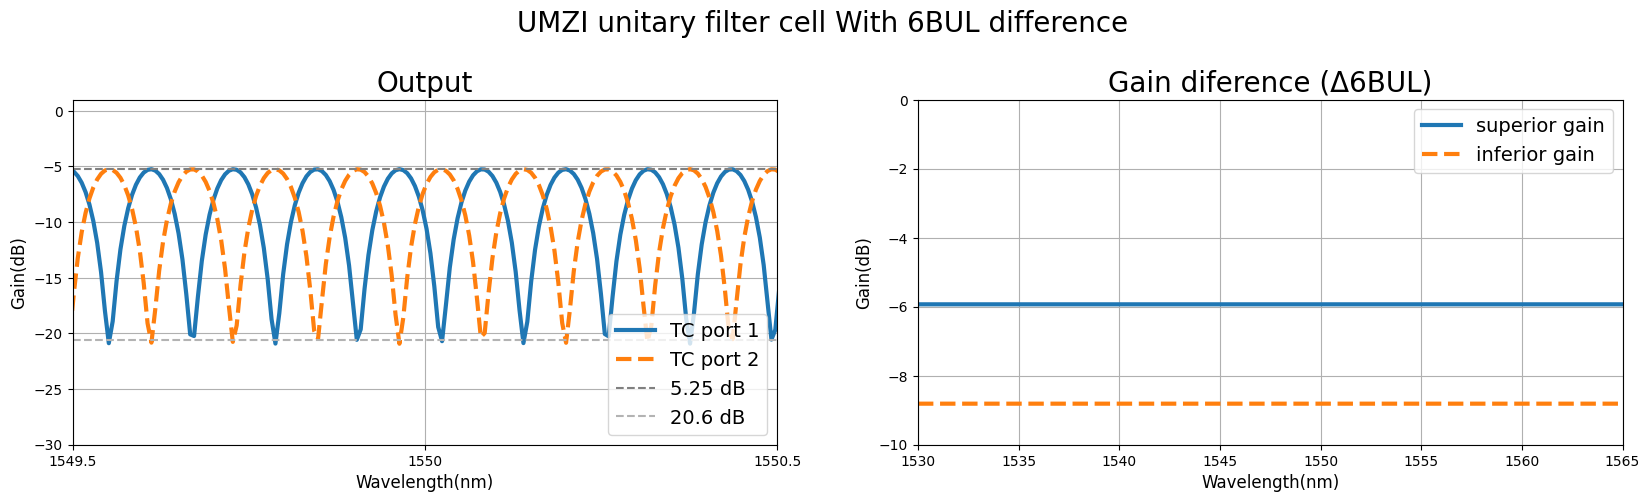

In [20]:
figure6,fig = plt.subplots(1,2,figsize=[20,5]);

#inter.run()

gainTC_p1 = inter.getresult('ONA_1','input 1/mode 1/gain')['TE gain (dB)']
gainTC_p2 = inter.getresult('ONA_1','input 2/mode 1/gain')['TE gain (dB)']
gainTC_p3 = inter.getresult('ONA_1','input 3/mode 1/gain')['TE gain (dB)']
gainTC_p4 = inter.getresult('ONA_1','input 4/mode 1/gain')['TE gain (dB)']

λ = np.linspace(simulation_band[0]*1e9,simulation_band[-1]*1e9, points)

figure6.suptitle('UMZI unitary filter cell With 6BUL difference', fontsize = 20)
figure6.subplots_adjust(top=0.8)

fig[0].set_title('Output', fontsize = 20)
fig[0].grid()
fig[0].plot(λ, gainTC_p1, label= 'TC port 1', linewidth = 3)
fig[0].plot(λ, gainTC_p2,'--', label = 'TC port 2', linewidth = 3)
fig[0].set_xlim(1549.5,1550.5)
fig[0].set_ylim(-30,1)
fig[0].set_xticks([1549.5, 1550, 1550.5], ['1549.5', '1550', '1550.5'])
fig[0].set_ylabel('Gain(dB)', fontsize=12)
fig[0].set_xlabel('Wavelength(nm)', fontsize=12)
fig[0].axhline(-5.25, label = '5.25 dB', color = 'grey', linestyle='--')
fig[0].axhline(-20.6, label = '20.6 dB', color = '0.7', linestyle='--')
fig[0].legend(fontsize = 14)

fig[1].set_title('Gain diference (Δ6BUL)', fontsize = 20)
fig[1].grid()
fig[1].plot(λ, gainTC_p3, label = 'superior gain', linewidth = 3)
fig[1].plot(λ, gainTC_p4,'--', label = 'inferior gain', linewidth = 3)
fig[1].legend(fontsize = 14)
fig[1].set_xlim(cband[0]*1e9,cband[-1]*1e9)
fig[1].set_ylim(-10,0)
fig[1].set_ylabel('Gain(dB)', fontsize=12)
fig[1].set_xlabel('Wavelength(nm)', fontsize=12)

figure7.savefig('../Media/UMZI Results/UMZI_unitary_cell_6BUL.png',bbox_inches='tight')

## Testing length diference with the same ΔBUL

In [ ]:
# Initializing INTERCONNECT
inter = lumapi.INTERCONNECT();

In [14]:
# Using 2 MZI Cells and 2ΔBULs

loss = 0.48
process = inter

cross = [0,0]
bar = [π,0]
Tc = [π/2,0]

inter.switchtolayout()
inter.selectall()
inter.delete()

# Creating  filter rings
theta_matrix = [cross,bar,cross,cross,cross,bar]
GenerateHexMZI(loss, process, theta_matrix)
inter.set({'x position':500,'y position':200})

theta_matrix = [bar,cross,cross,cross,cross,cross]
GenerateHexMZI(loss, process, theta_matrix)
inter.set({'x position':1200,'y position':0})

# Input MZI
inter.addelement('MZI_WITH_LOSS')
inter.set({'name': 'TC_in','Theta 1' : π/2,'x position':0,'y position':600, 'Loss': loss});

# Output MZI
inter.addelement('MZI_WITH_LOSS')
inter.set({'name': 'TC_out','Theta 1' : π/2,'x position':1800,'y position':600, 'Loss': loss});

Connectcomponents(inter, 'TC_in',[3,4],'MZI_HEX_1', [9,8]) # Tc_in to Filter 
Connectcomponents(inter, 'MZI_HEX_1',[2,3,5,4], 'MZI_HEX_2', [11,10,8,9]) # Cell 1 to Cell 2
Connectcomponents(inter, 'MZI_HEX_2',[4,5], 'TC_out',[1,2])  # Filter to Tc_out

ports = 6
points = 10001
addONA(inter, simulation_band[0],simulation_band[1],points,ports,250, 100)

inter.connect('ONA_1','output', 'TC_in', 'port 1')

inter.connect('ONA_1','input 1', 'TC_out', 'port 3')
inter.connect('ONA_1','input 2', 'TC_out', 'port 4');
inter.connect('ONA_1','input 3', 'MZI_HEX_2', 'port 4')
inter.connect('ONA_1','input 4', 'MZI_HEX_2', 'port 5');



In [15]:
inter.run()

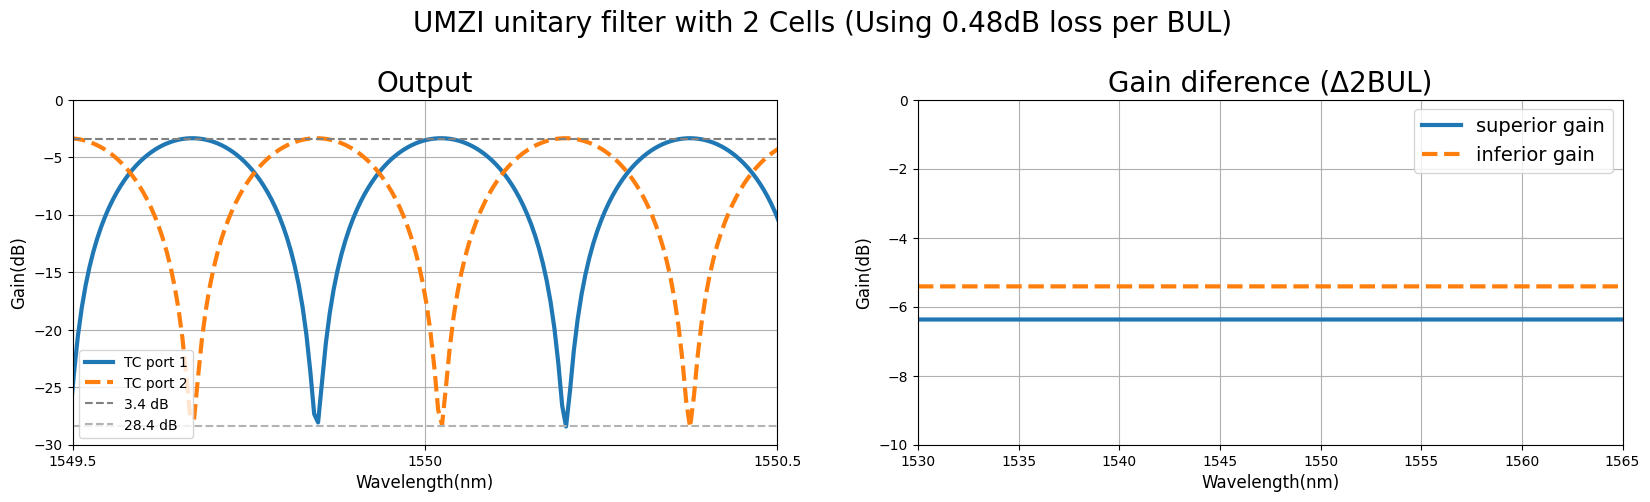

In [20]:
figure8,fig = plt.subplots(1,2,figsize=[20,5]);

gainTC_2p3 = inter.getresult('ONA_1','input 1/mode 1/gain')['TE gain (dB)']
gainTC_2p4 = inter.getresult('ONA_1','input 2/mode 1/gain')['TE gain (dB)']
gaincross_3p3 = inter.getresult('ONA_1','input 3/mode 1/gain')['TE gain (dB)']
gaincross_2p4 = inter.getresult('ONA_1','input 4/mode 1/gain')['TE gain (dB)']

λ = np.linspace(simulation_band[0]*1e9,simulation_band[-1]*1e9, points)

figure8.suptitle('UMZI unitary filter with 2 Cells (Using 0.48dB loss per BUL)', fontsize = 20)
figure8.subplots_adjust(top=0.8)

fig[0].set_title('Output', fontsize = 20)
fig[0].grid()
fig[0].plot(λ, gainTC_2p3, label= 'TC port 1', linewidth = 3)
fig[0].plot(λ, gainTC_2p4,'--', label = 'TC port 2', linewidth = 3)
fig[0].axhline(-3.4, label = '3.4 dB', color = 'grey', linestyle='--')
fig[0].axhline(-28.4, label = '28.4 dB', color = '0.7', linestyle='--')
fig[0].legend(fontsize = 10)
fig[0].set_xlim(1549.5,1550.5)
fig[0].set_ylim(-30,0)
fig[0].set_xticks([1549.5, 1550, 1550.5], ['1549.5', '1550', '1550.5'])
fig[0].set_ylabel('Gain(dB)', fontsize=12)
fig[0].set_xlabel('Wavelength(nm)', fontsize=12)

fig[1].set_title('Gain diference (Δ2BUL)', fontsize = 20)
fig[1].grid()
fig[1].plot(λ, gaincross_3p3, label = 'superior gain', linewidth = 3)
fig[1].plot(λ, gaincross_2p4,'--', label = 'inferior gain', linewidth = 3)
fig[1].legend(fontsize = 14)
fig[1].set_xlim(cband[0]*1e9,cband[-1]*1e9)
fig[1].set_ylim(-10,0)
fig[1].set_ylabel('Gain(dB)', fontsize=12)
fig[1].set_xlabel('Wavelength(nm)', fontsize=12)

figure8.savefig('../Media/UMZI Results/UMZI_unitary_cell_grain_2cells.png',bbox_inches='tight')

In [25]:
# Using 2 MZI Cells and 2ΔBULs

loss = 0.48
process = inter

cross = [0,0]
bar = [π,0]
Tc = [π/2,0]

inter.switchtolayout()
inter.selectall()
inter.delete()

# Creating  filter rings
theta_matrix = [cross,cross,cross,cross,cross,bar]
GenerateHexMZI(loss, process, theta_matrix)
inter.set({'x position':500,'y position':200})

theta_matrix = [bar,cross,cross,bar,cross,cross]
GenerateHexMZI(loss, process, theta_matrix)
inter.set({'x position':1200,'y position':0})

theta_matrix = [cross,cross,cross,bar,cross,cross]
GenerateHexMZI(loss, process, theta_matrix)
inter.set({'x position':1900,'y position':200})

# Input MZI
inter.addelement('MZI_WITH_LOSS')
inter.set({'name': 'TC_in','Theta 1' : π/2,'x position':0,'y position':600, 'Loss': loss});

# Output MZI
inter.addelement('MZI_WITH_LOSS')
inter.set({'name': 'TC_out','Theta 1' : π/2,'x position':2600,'y position':600, 'Loss': loss});

Connectcomponents(inter, 'TC_in',[3,4],'MZI_HEX_1', [9,8]) # Tc_in to Filter 
Connectcomponents(inter, 'MZI_HEX_1',[2,3,5,4], 'MZI_HEX_2', [11,10,8,9]) # Cell 1 to Cell 2
Connectcomponents(inter, 'MZI_HEX_2',[4,5,6,7], 'MZI_HEX_3',[1,12,11,10])  # Cell 1 to Cell 2 
Connectcomponents(inter, 'MZI_HEX_3', [4,5], 'TC_out', [1,2])

ports = 6
points = 10001
addONA(inter, simulation_band[0],simulation_band[1],points,ports,250, 100)

inter.connect('ONA_1','output', 'TC_in', 'port 1')

inter.connect('ONA_1','input 1', 'TC_out', 'port 3')
inter.connect('ONA_1','input 2', 'TC_out', 'port 4');
inter.connect('ONA_1','input 3', 'MZI_HEX_3', 'port 4')
inter.connect('ONA_1','input 4', 'MZI_HEX_3', 'port 5');



In [26]:
inter.run()

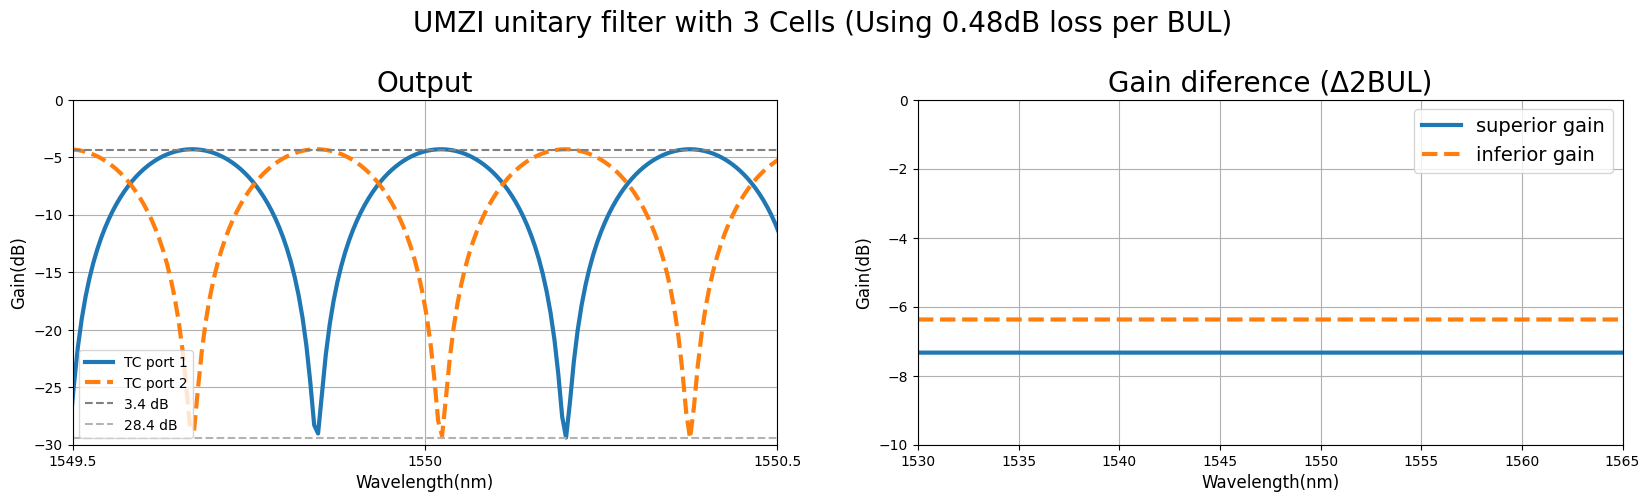

In [28]:
figure9,fig = plt.subplots(1,2,figsize=[20,5]);

gainTC_2p3 = inter.getresult('ONA_1','input 1/mode 1/gain')['TE gain (dB)']
gainTC_2p4 = inter.getresult('ONA_1','input 2/mode 1/gain')['TE gain (dB)']
gaincross_3p3 = inter.getresult('ONA_1','input 3/mode 1/gain')['TE gain (dB)']
gaincross_2p4 = inter.getresult('ONA_1','input 4/mode 1/gain')['TE gain (dB)']

λ = np.linspace(simulation_band[0]*1e9,simulation_band[-1]*1e9, points)

figure9.suptitle('UMZI unitary filter with 3 Cells (Using 0.48dB loss per BUL)', fontsize = 20)
figure9.subplots_adjust(top=0.8)

fig[0].set_title('Output', fontsize = 20)
fig[0].grid()
fig[0].plot(λ, gainTC_2p3, label= 'TC port 1', linewidth = 3)
fig[0].plot(λ, gainTC_2p4,'--', label = 'TC port 2', linewidth = 3)
fig[0].axhline(-4.4, label = '3.4 dB', color = 'grey', linestyle='--')
fig[0].axhline(-29.4, label = '28.4 dB', color = '0.7', linestyle='--')
fig[0].legend(fontsize = 10)
fig[0].set_xlim(1549.5,1550.5)
fig[0].set_ylim(-30,0)
fig[0].set_xticks([1549.5, 1550, 1550.5], ['1549.5', '1550', '1550.5'])
fig[0].set_ylabel('Gain(dB)', fontsize=12)
fig[0].set_xlabel('Wavelength(nm)', fontsize=12)

fig[1].set_title('Gain diference (Δ2BUL)', fontsize = 20)
fig[1].grid()
fig[1].plot(λ, gaincross_3p3, label = 'superior gain', linewidth = 3)
fig[1].plot(λ, gaincross_2p4,'--', label = 'inferior gain', linewidth = 3)
fig[1].legend(fontsize = 14)
fig[1].set_xlim(cband[0]*1e9,cband[-1]*1e9)
fig[1].set_ylim(-10,0)
fig[1].set_ylabel('Gain(dB)', fontsize=12)
fig[1].set_xlabel('Wavelength(nm)', fontsize=12)

figure9.savefig('../Media/UMZI Results/UMZI_unitary_cell_grain_3cells.png',bbox_inches='tight')

## Testing coupling diference

In [6]:
inter = lumapi.INTERCONNECT(filename='../cml/test.icp')

In [7]:
inter.switchtolayout()
inter.selectall()
inter.delete()

len = 46e-6
dlen = 91.2e-6

dx = 200

# Add the First order filter
inter.addelement('Waveguide Y Branch')
inter.set({'name': 'Splitter_1','x position':100,'y position':100, 'coupling coefficient 1': 0.5});
inter.set('coupling coefficient 2', inter.getnamed('Splitter_1','coupling coefficient 1'))

inter.addelement('Straight Waveguide')
inter.set({'name': 'Upper_1','y position':0,'x position':100+dx, 'length': len+dlen});
inter.addelement('Straight Waveguide')
inter.set({'name': 'Lower_1','y position':200,'x position':100+dx, 'length': len});

inter.addelement('Waveguide Y Branch')
inter.set({'name': 'Splitter_2','x position':100+2*dx,'y position':100, 'coupling coefficient 1': 0.5});
inter.set('coupling coefficient 2', inter.getnamed('Splitter_2','coupling coefficient 1'))
inter.rotateelement('Splitter_2')
inter.rotateelement('Splitter_2')

ports = 1
points = 10001
addONA(inter, simulation_band[0],simulation_band[1],points,ports,-200, 0)

# Connections

inter.connect('ONA_1','output',  'Splitter_1', 'port 1')
inter.connect('ONA_1','input 1', 'Splitter_2', 'port 1')

inter.connect('Splitter_1','port 2', 'Upper_1', 'port 1')
inter.connect('Splitter_1','port 3', 'Lower_1', 'port 1')
inter.connect('Splitter_2','port 3', 'Upper_1', 'port 2')
inter.connect('Splitter_2','port 2', 'Lower_1', 'port 2')


# Add the Second order filter
inter.addelement('Waveguide Y Branch')
inter.set({'name': 'Splitter_3','x position':100,'y position':500, 'coupling coefficient 1': 0.5});
inter.set('coupling coefficient 2', inter.getnamed('Splitter_3','coupling coefficient 1'))

inter.addelement('Straight Waveguide')
inter.set({'name': 'Upper_2','y position':400,'x position':100+dx, 'length': len+dlen});
inter.addelement('Straight Waveguide')
inter.set({'name': 'Lower_2','y position':600,'x position':100+dx, 'length': len});

inter.addelement('Waveguide Coupler')
inter.set({'name': 'Splitter_4','x position':100+2*dx,'y position':500, 'coupling coefficient 1': 0.29});
inter.set('coupling coefficient 2', inter.getnamed('Splitter_4','coupling coefficient 1'))

inter.addelement('Straight Waveguide')
inter.set({'name': 'Upper_3','y position':400,'x position':100+3*dx, 'length': len});
inter.addelement('Straight Waveguide')
inter.set({'name': 'Lower_3','y position':600,'x position':100+3*dx, 'length': len+2*dlen});

inter.addelement('Waveguide Coupler')
inter.set({'name': 'Splitter_5','x position':100+4*dx,'y position':500, 'coupling coefficient 1': 0.92});
inter.set('coupling coefficient 2', inter.getnamed('Splitter_5','coupling coefficient 1'))

ports = 2
points = 10001
addONA(inter, simulation_band[0],simulation_band[1],points,ports,-200,300)

# Connections

inter.connect('ONA_2','output',  'Splitter_3', 'port 1')
inter.connect('ONA_2','input 1', 'Splitter_5', 'port 3')
inter.connect('ONA_2','input 2', 'Splitter_5', 'port 4')

inter.connect('Splitter_3','port 2', 'Upper_2', 'port 1')
inter.connect('Splitter_3','port 3', 'Lower_2', 'port 1')
inter.connect('Splitter_4','port 1', 'Upper_2', 'port 2')
inter.connect('Splitter_4','port 2', 'Lower_2', 'port 2')
inter.connect('Splitter_4','port 3', 'Upper_3', 'port 1')
inter.connect('Splitter_4','port 4', 'Lower_3', 'port 1')
inter.connect('Splitter_5','port 1', 'Upper_3', 'port 2')
inter.connect('Splitter_5','port 2', 'Lower_3', 'port 2');

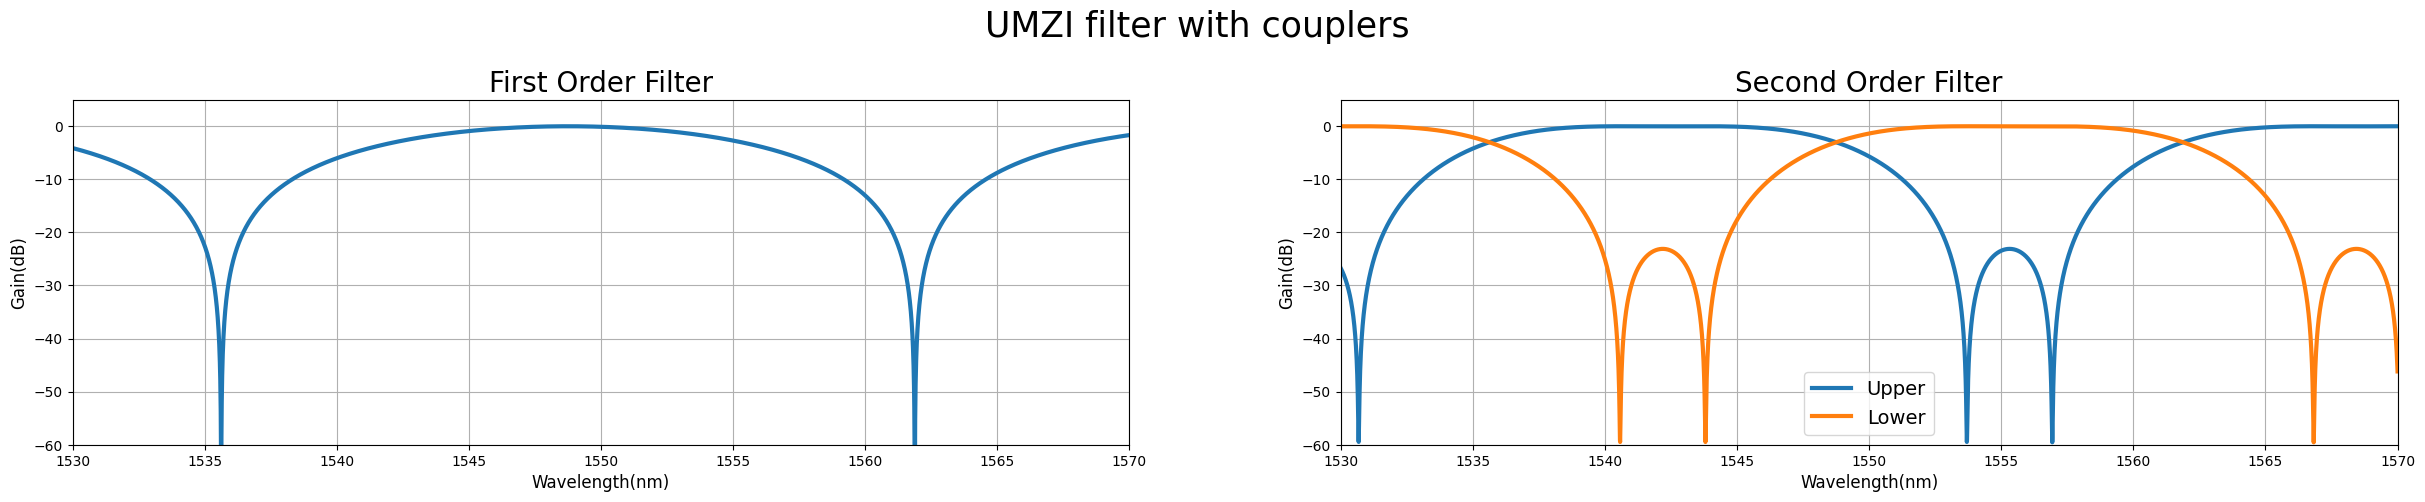

: 

In [9]:
inter.switchtolayout()
inter.run()

first = inter.getresult('ONA_1','input 1/mode 1/gain')['TE gain (dB)']
second_1 = inter.getresult('ONA_2','input 1/mode 1/gain')['TE gain (dB)']
second_2 = inter.getresult('ONA_2','input 2/mode 1/gain')['TE gain (dB)']

points = 10001
λ = np.linspace(simulation_band[0]*1e9,simulation_band[-1]*1e9, points)
figure10, fig = plt.subplots(1, 2, figsize=[30, 5])

figure10.suptitle('UMZI filter with couplers', fontsize=25)
figure10.subplots_adjust(top=0.8)

fig[0].set_title('First Order Filter', fontsize=20)
fig[0].grid()
fig[0].plot(λ, first, linewidth=3)
fig[0].set_xlim(1530, 1570)
fig[0].set_ylim(-60, 5)
fig[0].set_ylabel('Gain(dB)', fontsize=12)
fig[0].set_xlabel('Wavelength(nm)', fontsize=12)

fig[1].set_title('Second Order Filter', fontsize=20)
fig[1].grid()
fig[1].plot(λ, second_1,label='Upper', linewidth=3)
fig[1].plot(λ, second_2,label='Lower', linewidth=3)
fig[1].legend(fontsize=14)
fig[1].set_xlim(1530, 1570)
fig[1].set_ylim(-60, 5)
fig[1].set_ylabel('Gain(dB)', fontsize=12)
fig[1].set_xlabel('Wavelength(nm)', fontsize=12)


# Salvar a figura
figure10.savefig('../Media/UMZI Results/Coupling_Coeficient.png', bbox_inches='tight')


# Transmission in function of theta

In [10]:
inter = lumapi.INTERCONNECT()

In [7]:
## Using Ideal MZI cell

# Unitary UMZI cell
component_name = 'MZI_IDEAL_CELL'

inter.switchtolayout()
inter.selectall()
inter.delete()

# Create the MZIs

inter.addelement(component_name)
inter.set({'x position':-200,'y position':200,'name': 'MZI','Theta 1' : 0});

# Create the ONA
ports = 2
points = 10001
addONA(inter, simulation_band[0],simulation_band[1],points,ports,-250, 0)

inter.connect('ONA_1', 'output', 'MZI', 'port 1')
inter.connect('ONA_1', 'input 1', 'MZI', 'port 3')
inter.connect('ONA_1', 'input 2', 'MZI', 'port 4');

In [68]:
# Sweep Generation
n = 180
θ = np.linspace(-π*0.999,pi*0.999, n)

progress = tqdm(total= n)

transmission_1 = np.zeros(n)
transmission_2 = np.zeros(n)

for i in range(n):
    inter.switchtolayout()
    inter.setnamed('MZI', 'Theta 1', θ[i])
    inter.run()
    transmission_1[i] = abs(inter.getresult('ONA_1','input 1/mode 1/transmission')['TE transmission'][0])**2
    transmission_2[i] = abs(inter.getresult('ONA_1','input 2/mode 1/transmission')['TE transmission'][0])**2
    
    progress.update(1)

  0%|          | 0/180 [00:00<?, ?it/s]

KeyboardInterrupt: 

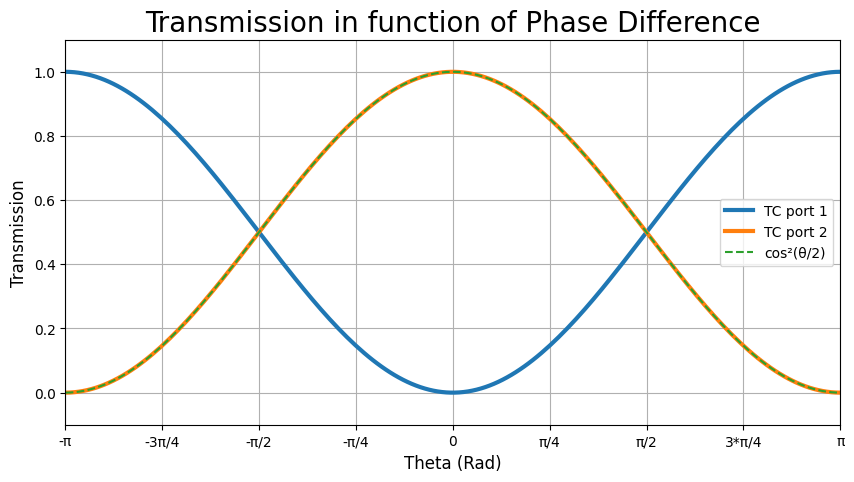

In [38]:
figure11 = plt.figure(figsize=[10,5]);

plt.title('Transmission in function of Phase Difference', fontsize = 20)
plt.grid()
plt.plot(θ, transmission_1, label= 'TC port 1', linewidth = 3)
plt.plot(θ, transmission_2, label = 'TC port 2', linewidth = 3)
plt.plot(θ, np.cos(θ/2)**2, '--', label = 'cos²(θ/2)')
plt.legend(fontsize = 10)
plt.xlim(θ[0],θ[-1])
plt.ylim(-0.1,1.1)
plt.xticks([-π, -3*π/4, -π/2, -π/4, 0, π/4, π/2, 3*π/4, π], ['-π', '-3π/4', '-π/2', '-π/4', '0', 'π/4', 'π/2', '3*π/4', 'π'])
plt.ylabel('Transmission', fontsize=12)
plt.xlabel('Theta (Rad)', fontsize=12)

figure11.savefig('../Media/Ideal MZI Cell.png',bbox_inches='tight')

In [151]:
# with the graph above, we can model the MZI 
# as an coupler with cos²(θ/2)

theta1 = 2*np.arccos(np.sqrt(0.5))
theta2 = 2*np.arccos(np.sqrt(0.29))
theta3 = 2*np.arccos(np.sqrt(0.92))
theta4 = 2*np.arccos(np.sqrt(0.2))
theta5 = 2*np.arccos(np.sqrt(0.04))


print('splitter 0.50 ->',theta1,'(rad)')
print('splitter 0.29 ->',theta2,'(rad)')
print('splitter 0.92 ->',theta3,'(rad)')
print('splitter 0.2 ->',theta4,'(rad)')
print('splitter 0.04 ->',theta5,'(rad)')



splitter 0.50 -> 1.5707963267948966 (rad)
splitter 0.29 -> 2.0042416468647826 (rad)
splitter 0.92 -> 2.5680795491666966 (rad)
splitter 0.2 -> 2.214297435588181 (rad)
splitter 0.04 -> 2.738876812009132 (rad)


In [13]:
# Input MZI
component_name = 'MZI_IDEAL_CELL'

inter.switchtolayout()
inter.selectall()
inter.delete()

len = 46e-6
dlen = 91.2e-6

# Add the two 'MZI' filter
inter.addelement(component_name)
inter.set({'name': 'Splitter_1','Theta 1' : theta1,'y position':100,'x position':400});
inter.addelement('Straight Waveguide')
inter.set({'name': 'Upper_1','y position':0,'x position':650, 'length': len+dlen});
inter.addelement('Straight Waveguide')
inter.set({'name': 'Lower_1','y position':200,'x position':650, 'length': len});

inter.addelement(component_name)
inter.set({'name': 'Splitter_2','Theta 1' :theta2,'y position':100,'x position':800});
inter.addelement('Straight Waveguide')
inter.set({'name': 'Upper_2','y position':0,'x position':1050, 'length': len});
inter.addelement('Straight Waveguide')
inter.set({'name': 'Lower_2','y position':200,'x position':1050, 'length': len+2*dlen});

inter.addelement(component_name)
inter.set({'name': 'Splitter_3','Theta 1' : theta3,'y position':100,'x position':1200});

# Add the three 'MZI' filter
inter.addelement(component_name)
inter.set({'name': 'Splitter_4','Theta 1' : theta1,'y position':500,'x position':400});
inter.addelement('Straight Waveguide')
inter.set({'name': 'Upper_4','y position':400,'x position':650, 'length': len+dlen});
inter.addelement('Straight Waveguide')
inter.set({'name': 'Lower_4','y position':600,'x position':650, 'length': len});

inter.addelement(component_name)
inter.set({'name': 'Splitter_5','Theta 1' : theta4,'y position':500,'x position':800});
inter.addelement('Straight Waveguide')
inter.set({'name': 'Upper_5','y position':400,'x position':1050, 'length': len});
inter.addelement('Straight Waveguide')
inter.set({'name': 'Lower_5','y position':600,'x position':1050, 'length': len+2*dlen});

inter.addelement(component_name)
inter.set({'name': 'Splitter_6','Theta 1' : theta4,'y position':500,'x position':1200});
inter.addelement('Straight Waveguide')
inter.set({'name': 'Upper_6','y position':400,'x position':1450, 'length': len});
inter.addelement('Straight Waveguide')
inter.set({'name': 'Lower_6','y position':600,'x position':1450, 'length': len+2*dlen});
inter.addelement('Optical Phase Shift')
inter.set({'name': 'Lower_6_Phase','y position':615,'x position':1600, 'phase shift':π})

inter.addelement(component_name)
inter.set({'name': 'Splitter_7','Theta 1' : theta5,'y position':500,'x position':1700});

# Add ONAs
ports = 2
points = 10001
addONA(inter, simulation_band[0],simulation_band[1],points,ports,100, 0)
addONA(inter, simulation_band[0],simulation_band[1],points,ports,100, 400)

# Connections

inter.connect('ONA_1','output', 'Splitter_1', 'port 1')
inter.connect('ONA_1','input 1', 'Splitter_3', 'port 3')
inter.connect('ONA_1','input 2', 'Splitter_3', 'port 4')

inter.connect('ONA_2','output', 'Splitter_4', 'port 1')
inter.connect('ONA_2','input 1', 'Splitter_7', 'port 3')
inter.connect('ONA_2','input 2', 'Splitter_7', 'port 4')

for i in [1,2,4,5,6]:
    inter.connect('Splitter_'+str(i), 'port 3', 'Upper_'+str(i), 'port 1')
    inter.connect('Splitter_'+str(i), 'port 4', 'Lower_'+str(i), 'port 1')
for i in [2,3,5,6]:
    inter.connect('Splitter_'+str(i), 'port 1', 'Upper_'+str(i-1), 'port 2')
    inter.connect('Splitter_'+str(i), 'port 2', 'Lower_'+str(i-1), 'port 2')

inter.connect('Upper_6', 'port 2', 'Splitter_7', 'port 1')
inter.connect('Lower_6', 'port 2', 'Lower_6_Phase', 'port 1')
inter.connect('Splitter_7', 'port 2', 'Lower_6_Phase', 'port 2');

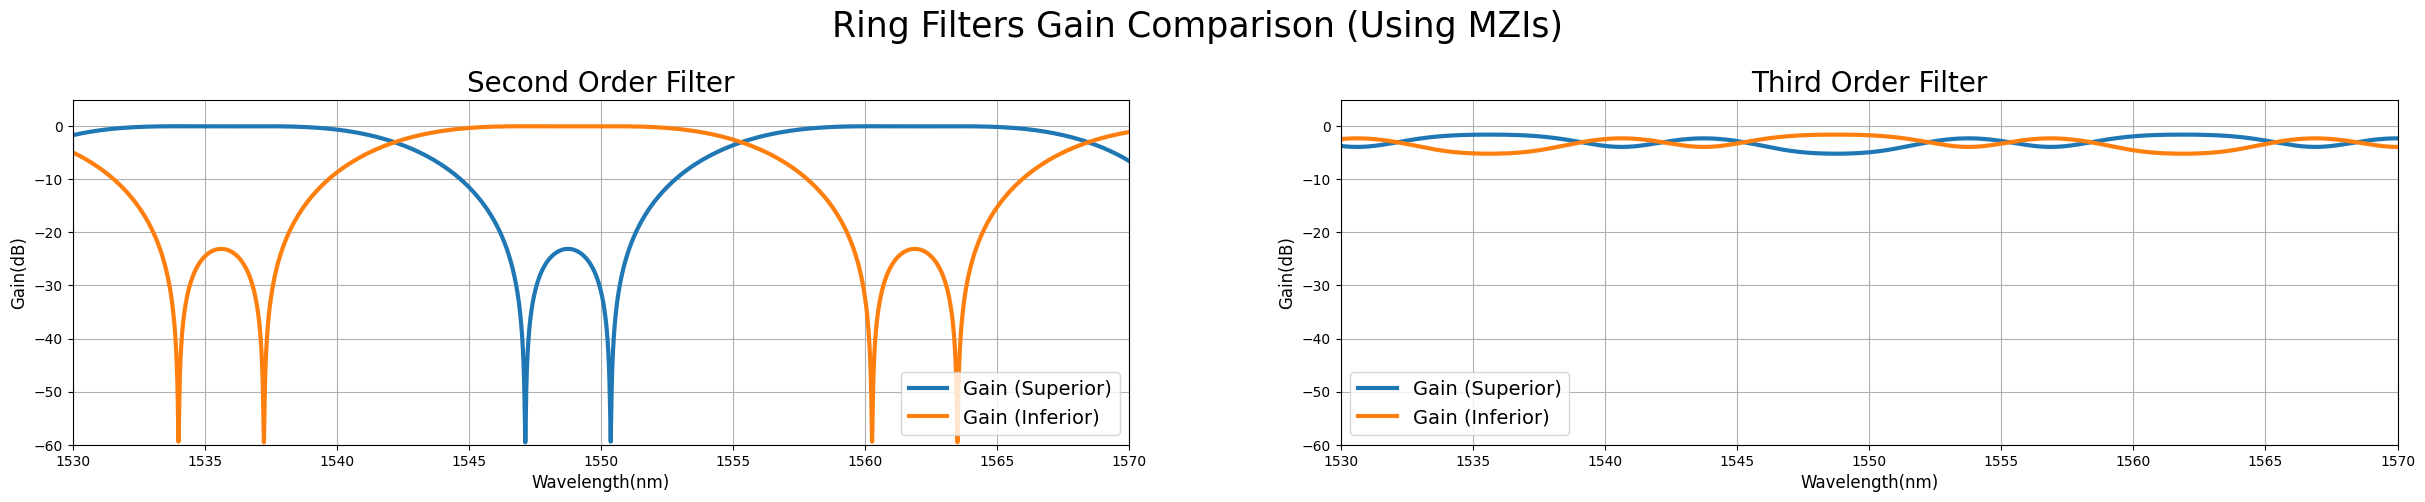

In [14]:
inter.switchtolayout()
inter.run()
second_1 = inter.getresult('ONA_1','input 1/mode 1/gain')['TE gain (dB)']
second_2 = inter.getresult('ONA_1','input 2/mode 1/gain')['TE gain (dB)']
third_1 = inter.getresult('ONA_2','input 1/mode 1/gain')['TE gain (dB)']
third_2 = inter.getresult('ONA_2','input 2/mode 1/gain')['TE gain (dB)']

points = 10001
λ = np.linspace(simulation_band[0]*1e9,simulation_band[-1]*1e9, points)
figure12, fig = plt.subplots(1, 2, figsize=[30, 5])

figure12.suptitle('Ring Filters Gain Comparison (Using MZIs)', fontsize=25)
figure12.subplots_adjust(top=0.8)

fig[0].set_title('Second Order Filter', fontsize=20)
fig[0].grid()
fig[0].plot(λ, second_1, label='Gain (Superior)', linewidth=3)
fig[0].plot(λ, second_2, label='Gain (Inferior)', linewidth=3)
fig[0].legend(fontsize=14)
fig[0].set_xlim(1530, 1570)
fig[0].set_ylim(-60, 5)
#fig[0].set_xticks([1540, 1550, 1560], ['1549.5', '1550', '1550.5'])
fig[0].set_ylabel('Gain(dB)', fontsize=12)
fig[0].set_xlabel('Wavelength(nm)', fontsize=12)

fig[1].set_title('Third Order Filter', fontsize=20)
fig[1].grid()
fig[1].plot(λ, third_1, label='Gain (Superior)', linewidth=3)
fig[1].plot(λ, third_2, label='Gain (Inferior)', linewidth=3)
fig[1].legend(fontsize=14)
fig[1].set_xlim(1530, 1570)
fig[1].set_ylim(-60, 5)
#fig[1].set_xticks([1549.5, 1550, 1550.5], ['1549.5', '1550', '1550.5'])
fig[1].set_ylabel('Gain(dB)', fontsize=12)
fig[1].set_xlabel('Wavelength(nm)', fontsize=12)

# Salvar a figura
figure12.savefig('../Media/UMZI Results/Coupling_Coeficient.png', bbox_inches='tight')


In [6]:
## MZI Hex Simulation and UMZI Third Order Generation

loss = 0
process = inter

cross = [0,0]
bar = [π,0]
Tc = [π/2,0]

inter.switchtolayout()
inter.selectall()
inter.delete()

# Creating first filter ring
theta_matrix1 = [bar,cross,cross,cross,cross,bar]
GenerateHexMZI(loss, process, theta_matrix1)
inter.set({'x position':200,'y position':400})

# Creating second filter ring
theta_matrix2 = [bar,bar,cross,cross,cross,cross]
GenerateHexMZI(loss, process, theta_matrix2)
inter.set({'x position':1200,'y position':400})

# Input MZI
inter.addelement('MZI_WITH_LOSS')
inter.set({'name': 'TC_in','Theta 1' : π/2,'x position':-200,'y position':800, 'Loss': loss});

# Filter 1 to 2 MZI
inter.addelement('Waveguide Coupler')
inter.set({'name': 'Coupler_1-2','x position':900,'y position':600, 'insertion loss': loss, 'coupling coefficient 1': 0.5});
inter.set('coupling coefficient 2', inter.getnamed('Coupler_1-2','coupling coefficient 1'))

# Filter 2 to out
inter.addelement('Waveguide Coupler')
inter.set({'name': 'Coupler_out','x position':1400,'y position':1000, 'insertion loss': loss, 'coupling coefficient 1': 0.3});
inter.set('coupling coefficient 2', inter.getnamed('Coupler_out','coupling coefficient 1'))

# Connections

Connectcomponents(inter, 'TC_in',[3,4], 'MZI_HEX_1', [9,8])   # Tc_In to Filter 1
Connectcomponents(inter, 'MZI_HEX_1',[4,5], 'Coupler_1-2',[1,2])   # Filter 1 to Coupler_1-2
Connectcomponents(inter, 'Coupler_1-2',[3,4],'MZI_HEX_2', [11,10]) # Coupler_1-2 to Filter 2
Connectcomponents(inter, 'MZI_HEX_2',[6,7], 'Coupler_out',[1,2])   # Filter 2 to Coupler_out

ports = 6
points = 10001
addONA(inter, simulation_band[0],simulation_band[1],points,ports,250, 250)

inter.connect('ONA_1','output', 'TC_in', 'port 1')
inter.connect('ONA_1','input 1', 'Coupler_1-2', 'port 3')
inter.connect('ONA_1','input 2', 'Coupler_1-2', 'port 4');
inter.connect('ONA_1','input 5', 'Coupler_out', 'port 3')
inter.connect('ONA_1','input 6', 'Coupler_out', 'port 4');